In [ ]:
import sys
import os
import importlib
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# --- 1. Path Setup ---
# Try to locate the repository root by searching upward for a 'src' directory (or .git)
def find_repo_root(start_path=None, marker_dirs=('src', '.git')):
    p = os.path.abspath(start_path or os.getcwd())
    while True:
        if any(os.path.isdir(os.path.join(p, m)) for m in marker_dirs):
            return p
        parent = os.path.dirname(p)
        if parent == p:
            return None
        p = parent

repo_root = find_repo_root()
# Fallback to previous hardcoded path if detection fails
if repo_root is None:
    repo_root = "/files/pixlball"

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print(f"Using repo_root: {repo_root}")

# --- 2. Project Module Imports ---
# Import all project modules using clean names
import src.config as config
import src.dataset as dataset
import src.train as train
import src.evaluate as evaluate
import src.data as data
import src.losses as losses
import src.model as model
import src.utils as utils
import src.xt_benchmark_gen as xT
import src.plotfunctions as plotfunctions


# --- 3. Module Reloading (CRITICAL for Notebook Development) ---
# Reload dependencies in order: Config/Utils -> Data/Losses/Model -> Train/Dataset/Evaluate
importlib.reload(config)
importlib.reload(utils)
importlib.reload(data)
importlib.reload(model)
importlib.reload(losses) 
importlib.reload(dataset)
importlib.reload(train)
importlib.reload(evaluate)
importlib.reload(xT)
importlib.reload(plotfunctions)


# --- 4. Direct Imports (For clean code in subsequent cells) ---
# Import essential classes and functions needed for the pipeline steps

# Configuration
from src.config import DEVICE 


# xT Benchmark
from src.xt_benchmark_gen import get_end_location, prepare_events, clip_locations, map_to_grid, compute_transition_matrices, compute_xT, plot_xT_grid, compute_player_cumulative_xT

# --- Final Check ---
print(f"Using device: {DEVICE}")


from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplsoccer
from mplsoccer import Pitch, VerticalPitch
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde
import seaborn as sns
import statsmodels.api as sm


Using repo_root: c:\Users\jonas\Desktop\repos\pixlball
Using device: cpu


In [2]:
all_events_df = pd.read_parquet(os.path.join(repo_root, "data", "events_data.parquet"), engine="fastparquet")

# Extract Data

In [3]:
events_xt = prepare_events(all_events_df)
events_clipped = clip_locations(events_xt)
events_grid = map_to_grid(events_clipped, num_x_cells=24, num_y_cells=16)
p_shot, p_transition, p_dead, xG_cell = compute_transition_matrices(events_grid, num_x_cells=24, num_y_cells=16)
xT_grid = compute_xT(p_shot, p_transition, xG_cell)

print("xT grid shape:", xT_grid.shape)

xT grid shape: (24, 16)


In [4]:
events_xt

,match_id,period,team_id,player_id,type,location,shot_statsbomb_xg,pass_outcome,shot_type,end_location
12,4020846,1,865,31534.0,Pass,"[61.0, 40.1]",NaN,None,None,"[26.4, 43.3]"
13,4020846,1,865,22032.0,Pass,"[28.5, 43.8]",NaN,None,None,"[83.6, 59.0]"
14,4020846,1,865,10178.0,Pass,"[83.6, 59.0]",NaN,None,None,"[91.8, 69.5]"
15,4020846,1,865,15555.0,Pass,"[91.8, 69.5]",NaN,None,None,"[95.1, 60.9]"
16,4020846,1,863,49836.0,Pass,"[11.1, 0.1]",NaN,None,None,"[16.0, 3.9]"
...,...,...,...,...,...,...,...,...,...,...
105524,3998841,2,853,10108.0,Shot,"[111.7, 41.5]",0.075132,None,Open Play,"[111.7, 41.5]"
105525,3998841,2,853,4650.0,Shot,"[104.4, 36.3]",0.028354,None,Open Play,"[104.4, 36.3]"
105526,3998841,2,853,87195.0,Shot,"[100.6, 26.2]",0.033323,None,Open Play,"[100.6, 26.2]"
105527,3998841,2,858,10229.0,Shot,"[113.0, 45.7]",0.091894,None,Open Play,"[113.0, 45.7]"


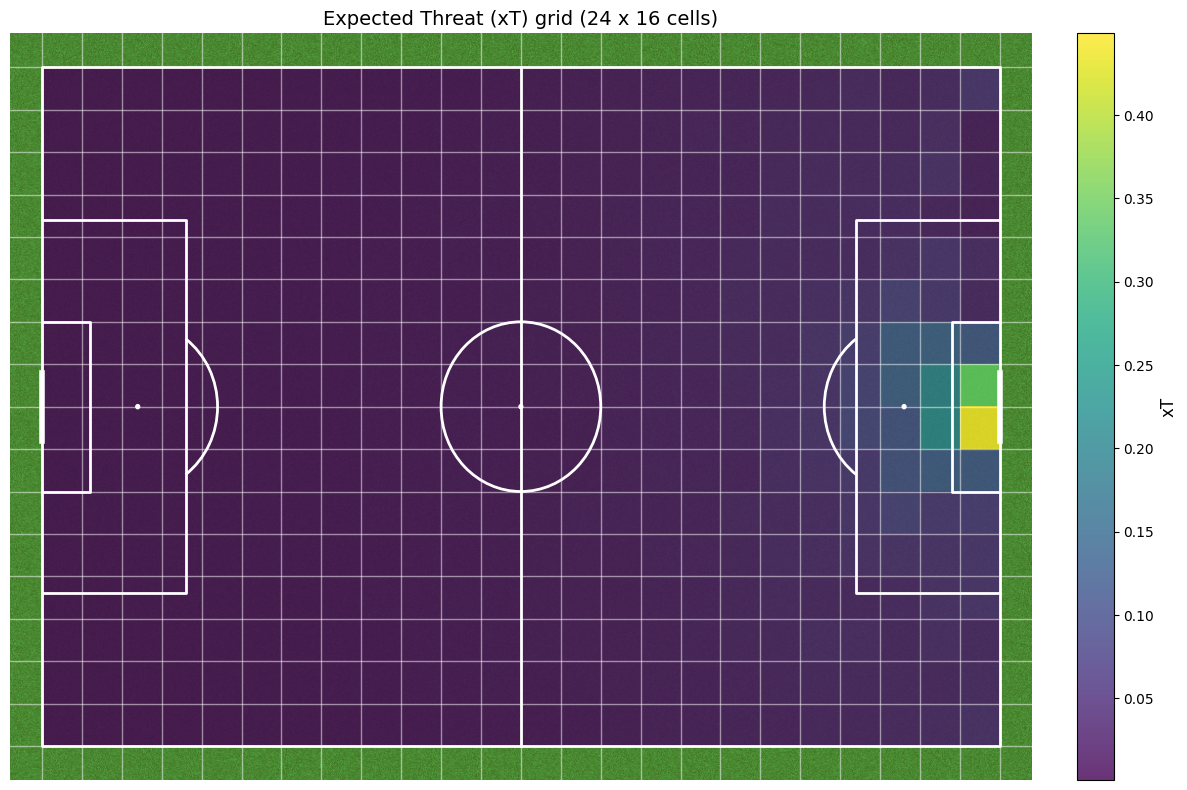

In [6]:
plot_xT_grid(xT_grid, num_x_cells=24, num_y_cells=16)

In [7]:
xt_final_with_targets, player_xt_cumulative = compute_player_cumulative_xT(events_xt, all_events_df, xT_grid)

In [8]:
player_xt_cumulative.head(10)

,cum_xT,player_name
player_id,,
10161.0,5.862937,María Francesca Caldentey Oliver
10143.0,5.825036,Alexia Putellas Segura
15287.0,5.413496,Patricia Guijarro Gutiérrez
15284.0,5.174647,Aitana Bonmati Conca
50146.0,4.873003,Esther Gonzalez Rodríguez
46639.0,4.724903,Ona Batlle Pascual
10178.0,4.521089,Lucy Bronze
10165.0,4.365646,Irene Paredes Hernandez
31534.0,4.100932,Ella Toone
